# Fitting Rotation Maps

A common task for analyses of protoplanetary disks is to infer their geometrical properties, namely the source centre, $(x_0,\, y_0)$, the inclination $i$, position angle ${\rm PA}$ and stellar (dynamical) mass, $M_{\rm star}$, by fitting a simple Keplerian rotation pattern to a measured rotation pattern. In this notebook we'll use the lovely high resolution 12CO data of TW Hya from [Huang et al. (2018)](https://ui.adsabs.harvard.edu/#abs/2018ApJ...852..122H), which is available [here](https://dataverse.harvard.edu/dataset.xhtml?persistentId=doi:10.7910/DVN/PXDKBC), to measure these properties and look at how we can use this to constrain the rotation direction of this disk. 

## Making a Rotation Map

There are many different ways of collapsing a cube to a velocity map which will be discussed in a future notebook. For now, we'll use the method presented in [Teague & Foreman-Mackey (2018)](https://ui.adsabs.harvard.edu/#abs/2018RNAAS...2c.173T) to calculate the projected line-of-sight velocity maps. For this we can use the functions in `collapse_cube.py`. Calling it from the command line will use default values (which work well for most cases), however more control can be had by calling the functions interactively.

The standard call would be:

```
python collapse_cube.py name_of_file.fits [-clip SNR]
```

where you can use the `-clip SNR` argument to mask all values less than the given `SNR` value. This will make four new FITS files with the filename `*_v0.fits` and `*_Fnu.fits` which correspond to the line centre (equivalent to the first moment) and line peak (equivalent to the eighth moment). There will also be associated uncertainty maps for these two.

## Loading up the Rotation Map

Within `fit_cube.py` we have defined a `rotationmap` class which provides all the functionality we'll need. Let's load it up.

In [1]:
%matplotlib inline
from eddy.fit_cube import rotationmap

When loading the data we need _at least_ the rotation map. If you have a map of the uncertainties for each pixel, they can be included with the `uncertainty` argument. If you don't, that's OK as it was assume a 10% uncertainty on each pixel by default. This can be changed through the `cube.error` parameter. We have also downsampled the data by a factor of 5 to make the fitting faster. This is optional but useful for speeding up things when you're playing around.

For this example here I have used CASA to clip the image down to the inner region of interest. However, if you want to keep your whole FITS cube you can use the `clip` argument which will clip your data down to a given offset.

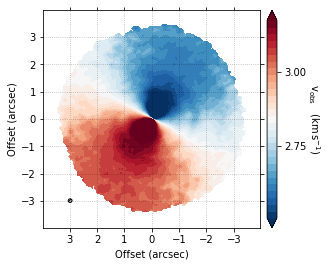

In [2]:
# Load up the data.

cube = rotationmap(path='./Cubes/dataverse_TWHya_CO_cube_v0.fits',
                   uncertainty='./Cubes/dataverse_TWHya_CO_cube_dv0.fits',
                   downsample=5)

# Inspect the data.

cube.plot_data()

## Fitting the Rotation Map

Here we describe how to fit the data using the `fit_keplerian()` function.

### Thin Keplerian Disk

First off we assume a geometrically thin disk where

$$v_{\rm proj} = \sqrt{\frac{GM_{\rm star}}{r}} \cdot \cos \theta \cdot \sin i + v_{\rm LSR} \quad \text{or} \quad v_{\rm proj} = v_{\rm kep} \cdot \cos \theta \cdot \sin i + v_{\rm LSR} $$

where $\theta$ is the position angle of the pixel (measured east of north) and $v_{\rm LSR}$ is the systemic velocity. Thus we can fully describe the rotation pattern with five free parameters.

For the fitting, we need to know which of these values we're fixing and which we want to fit for. Given the extreme degeneracy between $i$ and $M_{\rm star}$, a good idea is to fix $i$ to a value found from fitting the continuum. So, for this example we want to find the source center, $(x0,\,  y0)$, the position angle of the disk, ${\rm PA}$, the stellar mass $M_{\rm star}$ and the systemic velocity, $v_{\rm LSR}$, while holding the inclination fixed at $i = 6.8^{\circ}$.

We the provide two things to `fit_keplerian()`: `p0`, a list of the initial guesses for the free parameters and `params`, which is a dictionary containing a) the indices of the free variables in `p0` as an **integer** and b) the fixed values for all other variables as a **float**.

In [3]:
params = {}

# Start with the positions of the free variables in p0.

params['x0'] = 0
params['y0'] = 1
params['PA'] = 2
params['mstar'] = 3
params['vlsr'] = 4

p0 = [0.0, 0.0, 151., 0.65, 2.8e3]

# Fix the other parameters.

params['inc'] = 6.8  # degrees
params['dist'] = 60.1  # parsec
params['beam'] = False  # should we convolve the model? **MUST BE A BOOLEAN**

# We must also specify the region to fit as we do not want to fit outside the map.
# This can be done with the `r_min` and `r_max` values. An inner radius is sometimes
# useful if the beam smearing in the inner region strongly affects the fit.

r_min = 0.05
r_max = 3.25

The fitting has several steps:

1. Using the initial values in `p0` to deproject the data, it will create a mask of the regions to fit. This will be plotted as black contours over the original data.
2. If `optimize=True`, which is strongly recommended, it tries to find the values in `p0` which maximize the likelihood function. Using these updated `p0` values it will then recalculate the regions to fit.
3. It will sample the posterior distributions using `emcee`, returning either the 16th, 50th and 84th percentiles of the posterior distributions, or, if `return_samples=True`, will return all the samples of the posteriors.
4. It will the make diagnostic plots, included median model, corner covariance plots and traces.

In [ ]:
cube.fit_keplerian(p0=p0, params=params, r_min=r_min, r_max=r_max, nwalkers=256, nburnin=100, nsteps=100)

Assuming
	p0 = [x0, y0, PA, mstar, vlsr].
Optimized starting positions:
	p0 = ['-3.9849e-03', '9.5468e-03', '1.5144e+02', '5.9719e-01', '2.8415e+03']


### Geometrically Thick Disk

We can go beyond the geometrically thin disk approximation and use a more realistic 3D structure. Here we assume an azimuthually symmetric emission surface parameterized by $z(r) = z_0 \cdot (r \, / \, 1^{\prime\prime})^{\varphi}$. With this we can recover the geometrically thin limit when $z_0 = 0$ and the conical surface discussed in [Rosenfeld et al. (2013)](https://ui.adsabs.harvard.edu/#abs/2013ApJ...774...16R).

This will have two affects. Firstly, it will alter the deprojection which will have most significant affects along the semi-minor axis. Secondly, we have to correct $v_{\rm kep}$ for a) the additional distance to the star from an elevated location (difference in a radial polar coordinate and a radial cylindrical coordinate), and b) the projected gravitational force, resulting in,

$$v_{\rm kep} = \sqrt{\frac{GM_{\rm star}r^2}{(r^2 + z^2)^{3\,/\,2}}},$$

where $r$ is the cylindrical (or midplane) radius.

To include this in our model we need three more parameters: `z0`, `psi` and `tilt`. The first two define the emission surface profile, the latter, a value $-1 \leq {\rm tilt} \leq 1$, describes where the northern half is closer to the observer, ${\rm tilt} \geq 0$, or the southern side is, ${\rm tilt} < 0$. Aside: this is not the best way to implement this, but I have yet to settle on a reasonable alternative.

In [ ]:
params = {}

# Start with the positions of the free variables in p0.
# Note that as we have non-zero z values we must keep Mstar
# a free parameter to account for this change.\

p0 = [0.2, 0.8, 0.0, 0.59]
params['z0'] = 0
params['psi'] = 1
params['tilt'] = 2
params['mstar'] = 3

# Fix the other parameters.

params['x0'] = -4e-3  # arcsec
params['y0'] = 9.8e-3  # arcsec
params['PA'] = 151.5  # degrees
params['vlsr'] = 2841.  # systemic velocities
params['inc'] = 6.8  # degrees
params['dist'] = 60.1  # parsec
params['beam'] = False  # should we convolve the model? **MUST BE A BOOLEAN**

In [ ]:
cube.fit_keplerian(p0=p0, params=params, r_min=r_min, r_max=r_max, nwalkers=64, nburnin=500, nsteps=100)